In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels 
from statsmodels.tsa import stattools

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statannotations.Annotator import Annotator

from ssm_stats import EsmssmStats
stats = EsmssmStats()
from ssm_prep_data import EsmssmDataPrep
prep = EsmssmDataPrep()
from ssm_plotting import EsmssmPlotting
plotting = EsmssmPlotting()

# Define filepath
filepath = '../../results/modelfits/'

# Define path to save figures
figpath = '../../results/paper_figures/'
savefig = False

In [2]:
# Load twinsscan dataset
df = pd.read_csv(filepath + '../../data/data_prep/twindata/mooddata.csv', delimiter=',')
df_input = pd.read_csv(filepath + '../../data/data_prep/twindata/inputdata.csv')

# Load modelfit for twinsscan dataset
mat = scipy.io.loadmat(filepath + 'twindata/ssmfit_inp2.mat')

# Number of subjects
Nsj = len(mat['fit'][0])

# Define dimensions
mood_columns = ['cheerful', 'content', 'anxious', 'sad']

# Define dynamic matrix labels
A_columns = [mood_columns[j] + r' $\rightarrow$ ' + mood_columns[i] for i in range(4) for j in range(4)]
A_columns_idx = [mood_columns[j] + r' $\rightarrow$ ' + mood_columns[i] + r' (a$_{' + \
                 str(i+1) + str(j+1) + '}$)' for i in range(4) for j in range(4)]

In [3]:
# Extract parameter estimates from mat file
data = []
for i in range(Nsj):
    subdata = dict()
    subdata['timing'] = mat['fit'][0][i][0][0][1]
    subdata['numberMeasurements'] = len(subdata['timing'])
    subdata['data'] = mat['fit'][0][i][0][0][2]
    subdata['datamean'] = np.nanmean(subdata['data'],1)
    subdata['inp'] = mat['fit'][0][i][0][0][3]
    subdata['A'] = mat['fit'][0][i][0][0][4]['A'][0][0] + mat['fit'][0][i][0][0][4]['W'][0][0]
    subdata['bias'] = mat['fit'][0][i][0][0][4]['h'][0][0]
    subdata['C'] = mat['fit'][0][i][0][0][4]['C'][0][0]
    subdata['latents'] = mat['fit'][0][i][0][0][4]['z'][0][0]
    subdata['ll'] = mat['fit'][0][i][0][0][4]['LL'][0][0][0]
    data.append(subdata)

In [4]:
# Create depression and input dataframes
df_depression = pd.DataFrame()
sub_list = df['id'].unique()
Nsj = len(sub_list)
ii = df_input.copy()
input_columns = df_input.columns[2:]
actual_inputs = np.empty(((len(input_columns)),Nsj))
for d in ['1', '2', '_change']:
    for j, i in enumerate(sub_list):
        idx = df['id'] == i
        df_depression.loc[j, 'dep' + d] = df['dep_9f' + d][idx].iloc[0]
        actual_inputs[:,j] = ~np.isnan(ii[idx].iloc[0,2:]).values
        
for i in ['dep1', 'dep2', 'dep_change']:
    for g in range(2):
        df_depression[i + '_zscore'] = scipy.stats.zscore(df_depression[i], nan_policy='omit')
        
C_labels = [i + ' - ' + j for i in mood_columns for j in input_columns]

In [5]:
# Summary statistics
df_summary_stats = pd.DataFrame()
df_summary_stats.loc[0, 'N = ' + str(len(df['id'].unique()))] = str(df['id'].value_counts().mean().round()) + ' ± ' + str(df['id'].value_counts().std().round())
means = df[[j for j in df.columns if 'mood' in j]+['id', 'dep_9f1', 'dep_9f2']].groupby('id').mean().mean().round(2)
stds = df[[j for j in df.columns if 'mood' in j]+['id', 'dep_9f1', 'dep_9f2']].groupby('id').mean().std().round(2)
for k in range(len(means)):
    df_summary_stats.loc[k+1,'N = ' + str(len(df['id'].unique()))] = str(means[k]) + ' ± ' + str(stds[k])
df_summary_stats.index = ['# of measurments'] + mood_columns + ['depression_baseline', 'depression_followup']
df_summary_stats

,N = 439
# of measurments,49.0 ± 6.0
cheerful,4.83 ± 0.85
content,5.14 ± 0.66
anxious,1.72 ± 0.64
sad,1.48 ± 0.5
depression_baseline,0.56 ± 0.53
depression_followup,0.52 ± 0.5


In [6]:
# Extract dynamics and control features
dynamics, basic_char = prep.extract_dynamic_features(data, control_features=True, input_columns=input_columns, inputs=actual_inputs)

<Axes: >

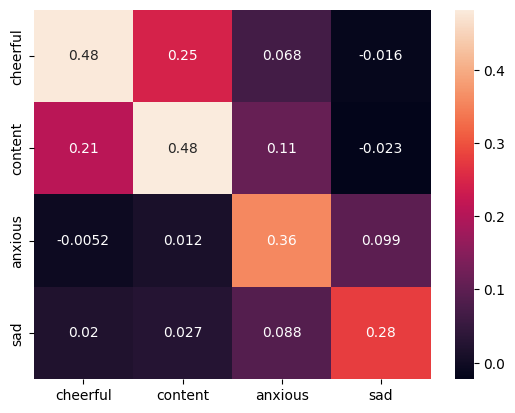

In [7]:
import seaborn as sns
# dynamics matrix very similar to control matrix in leemput dataset
sns.heatmap(np.nanmean(dynamics['matrix_hour'],axis=2), annot=True, \
            yticklabels=mood_columns, xticklabels=mood_columns)

In [8]:
# Regression between matrix items and depression score
score ='dep1'
par = [dynamics['matrix'], dynamics['matrix_hour'], dynamics['VAR']]

df_reg_matrix = pd.DataFrame()
for parameter in par:
    parameter = np.reshape(parameter, (16, Nsj))
    tmp = stats.depression_relations(parameter, df_depression[score], \
                            ['rspear', 'pvalue'], A_columns_idx)

    df_reg_matrix = pd.concat((df_reg_matrix,tmp),axis=1)
header = [np.repeat(np.array(['dynamics matrix (min)', 'dynamics matrix (h)', 'VAR']),len(df_reg_matrix.columns.unique())), \
          np.array(len(['dynamics matrix (min)', 'dynamics matrix (h)', 'VAR'])*['rspear', 'pvalue']).flatten()]
df_reg_matrix.columns = header
display(df_reg_matrix)
# print(df_reg_matrix.to_latex(float_format='%.2f'))

dynamics matrix (min)            \
                                                          rspear    pvalue   
cheerful $\rightarrow$ cheerful (a$_{11}$)                  0.04     0.352   
content $\rightarrow$ cheerful (a$_{12}$)                  -0.04     0.429   
anxious $\rightarrow$ cheerful (a$_{13}$)                  -0.09     0.048   
sad $\rightarrow$ cheerful (a$_{14}$)                      -0.04      0.45   
cheerful $\rightarrow$ content (a$_{21}$)                   0.06     0.189   
content $\rightarrow$ content (a$_{22}$)                   -0.02     0.703   
anxious $\rightarrow$ content (a$_{23}$)                   -0.10     0.046   
sad $\rightarrow$ content (a$_{24}$)                       -0.06     0.198   
cheerful $\rightarrow$ anxious (a$_{31}$)                  -0.02     0.666   
content $\rightarrow$ anxious (a$_{32}$)                   -0.09     0.054   
anxious $\rightarrow$ anxious (a$_{33}$)                    0.25  $<$0.001   
sad $\rightarrow$ anxious (a$_{34}$)                       -0.05     0.278   
cheerful $\rightarrow$ sad (a$_{41}$)                       0.02     0.687   
content $\rightarrow$ sad (a$_{42}$)                       -0.16     0.001   
anxious $\rightarrow$ sad (a$_{43}$)                       -0.14     0.004   
sad $\rightarrow$ sad (a$_{44}$)                            0.28  $<$0.001   

                                           dynamics matrix (h)            \
                                                        rspear    pvalue   
cheerful $\rightarrow$ cheerful (a$_{11}$)                0.04     0.373   
content $\rightarrow$ cheerful (a$_{12}$)                -0.04     0.419   
anxious $\rightarrow$ cheerful (a$_{13}$)                -0.09      0.05   
sad $\rightarrow$ cheerful (a$_{14}$)                     0.03     0.477   
cheerful $\rightarrow$ content (a$_{21}$)                 0.05     0.296   
content $\rightarrow$ content (a$_{22}$)                 -0.01     0.828   
anxious $\rightarrow$ content (a$_{23}$)                 -0.10     0.034   
sad $\rightarrow$ content (a$_{24}$)                      0.01     0.876   
cheerful $\rightarrow$ anxious (a$_{31}$)                -0.02     0.616   
content $\rightarrow$ anxious (a$_{32}$)                 -0.02     0.709   
anxious $\rightarrow$ anxious (a$_{33}$)                  0.25  $<$0.001   
sad $\rightarrow$ anxious (a$_{34}$)                      0.09     0.051   
cheerful $\rightarrow$ sad (a$_{41}$)                     0.00     0.963   
content $\rightarrow$ sad (a$_{42}$)                     -0.07     0.168   
anxious $\rightarrow$ sad (a$_{43}$)                      0.04     0.403   
sad $\rightarrow$ sad (a$_{44}$)                          0.26  $<$0.001   

                                              VAR            
                                           rspear    pvalue  
cheerful $\rightarrow$ cheerful (a$_{11}$)   0.01     0.769  
content $\rightarrow$ cheerful (a$_{12}$)   -0.06     0.254  
anxious $\rightarrow$ cheerful (a$_{13}$)   -0.09     0.087  
sad $\rightarrow$ cheerful (a$_{14}$)        0.04     0.437  
cheerful $\rightarrow$ content (a$_{21}$)    0.02     0.662  
content $\rightarrow$ content (a$_{22}$)    -0.04     0.406  
anxious $\rightarrow$ content (a$_{23}$)    -0.10     0.049  
sad $\rightarrow$ content (a$_{24}$)        -0.03     0.616  
cheerful $\rightarrow$ anxious (a$_{31}$)   -0.04     0.397  
content $\rightarrow$ anxious (a$_{32}$)    -0.05     0.321  
anxious $\rightarrow$ anxious (a$_{33}$)     0.18  $<$0.001  
sad $\rightarrow$ anxious (a$_{34}$)        -0.03     0.523  
cheerful $\rightarrow$ sad (a$_{41}$)        0.00     0.981  
content $\rightarrow$ sad (a$_{42}$)        -0.00     0.931  
anxious $\rightarrow$ sad (a$_{43}$)         0.10     0.055  
sad $\rightarrow$ sad (a$_{44}$)             0.06     0.232

In [9]:
# Regression between dynamic features and depression score
score ='dep1'
parameter_labels = ['eigenvalues', 'slowest eigenvector', 'fastest eigenvector', 'singular values', 'most controllable direction', 'variabilty', 'instability', 'inertia', 'mean']
par = [dynamics['val'], dynamics['stab'], np.abs(dynamics['vec'][:,0,:]), np.abs(dynamics['vec'][:,-1,:]), \
                    dynamics['conval'], np.abs(dynamics['convec'][:,0,:]), basic_char['variance'], basic_char['RMSSD'], \
                    basic_char['AR'], basic_char['mean']]

df_reg_dynamics = pd.DataFrame()
for i, parameter in enumerate(par):

    if parameter.ndim == 1: column_names = ['overall stability']
    else: column_names = mood_columns
    tmp = stats.depression_relations(parameter, df_depression[score], \
                            ['rspear', 'pvalue'], column_names)
    
    df_reg_dynamics = pd.concat((df_reg_dynamics,tmp),axis=0)

header = [np.concatenate((np.repeat(np.array(parameter_labels[0]),5),np.repeat(np.array(parameter_labels[1:]),4))), 
                    np.concatenate((np.array(['1st', '2nd', '3rd', '4th','overall stability']), \
                                    np.array(len(parameter_labels[1:])*mood_columns)))]
df_reg_dynamics.index = header
display(df_reg_dynamics)
# print(df_reg_matrix.to_latex(float_format='%.2f'))

rspear    pvalue
eigenvalues                 1st                  0.13     0.006
                            2nd                  0.15     0.001
                            3rd                  0.25  $<$0.001
                            4th                  0.30  $<$0.001
                            overall stability    0.30  $<$0.001
slowest eigenvector         cheerful            -0.14     0.005
                            content             -0.07     0.151
                            anxious              0.19  $<$0.001
                            sad                  0.13     0.006
fastest eigenvector         cheerful             0.14     0.003
                            content              0.16  $<$0.001
                            anxious              0.03     0.577
                            sad                 -0.14     0.003
singular values             cheerful            -0.03     0.499
                            content             -0.01     0.913
                            anxious              0.03      0.47
                            sad                  0.11      0.02
most controllable direction cheerful            -0.13     0.008
                            content             -0.14     0.003
                            anxious              0.30  $<$0.001
                            sad                  0.13     0.006
variabilty                  cheerful             0.08     0.098
                            content              0.08     0.085
                            anxious              0.38  $<$0.001
                            sad                  0.36  $<$0.001
instability                 cheerful             0.07     0.129
                            content              0.04     0.357
                            anxious              0.34  $<$0.001
                            sad                  0.34  $<$0.001
inertia                     cheerful             0.02       0.7
                            content              0.08     0.096
                            anxious              0.22  $<$0.001
                            sad                  0.15     0.003
mean                        cheerful            -0.31  $<$0.001
                            content             -0.41  $<$0.001
                            anxious              0.46  $<$0.001
                            sad                  0.40  $<$0.001

['sad', 'At home.', 0.31471819535798345, 3.7645801491238156, 0.000189678635799892]
['sad', 'Public places outdoors.', 0.34754466115454197, 3.6733408214201373, 0.0002748161383278915]
['sad', 'Work.', 0.3506437924165667, 3.51588258150124, 0.000502207646902329]
multiple comparison: 0.0005208333333333333


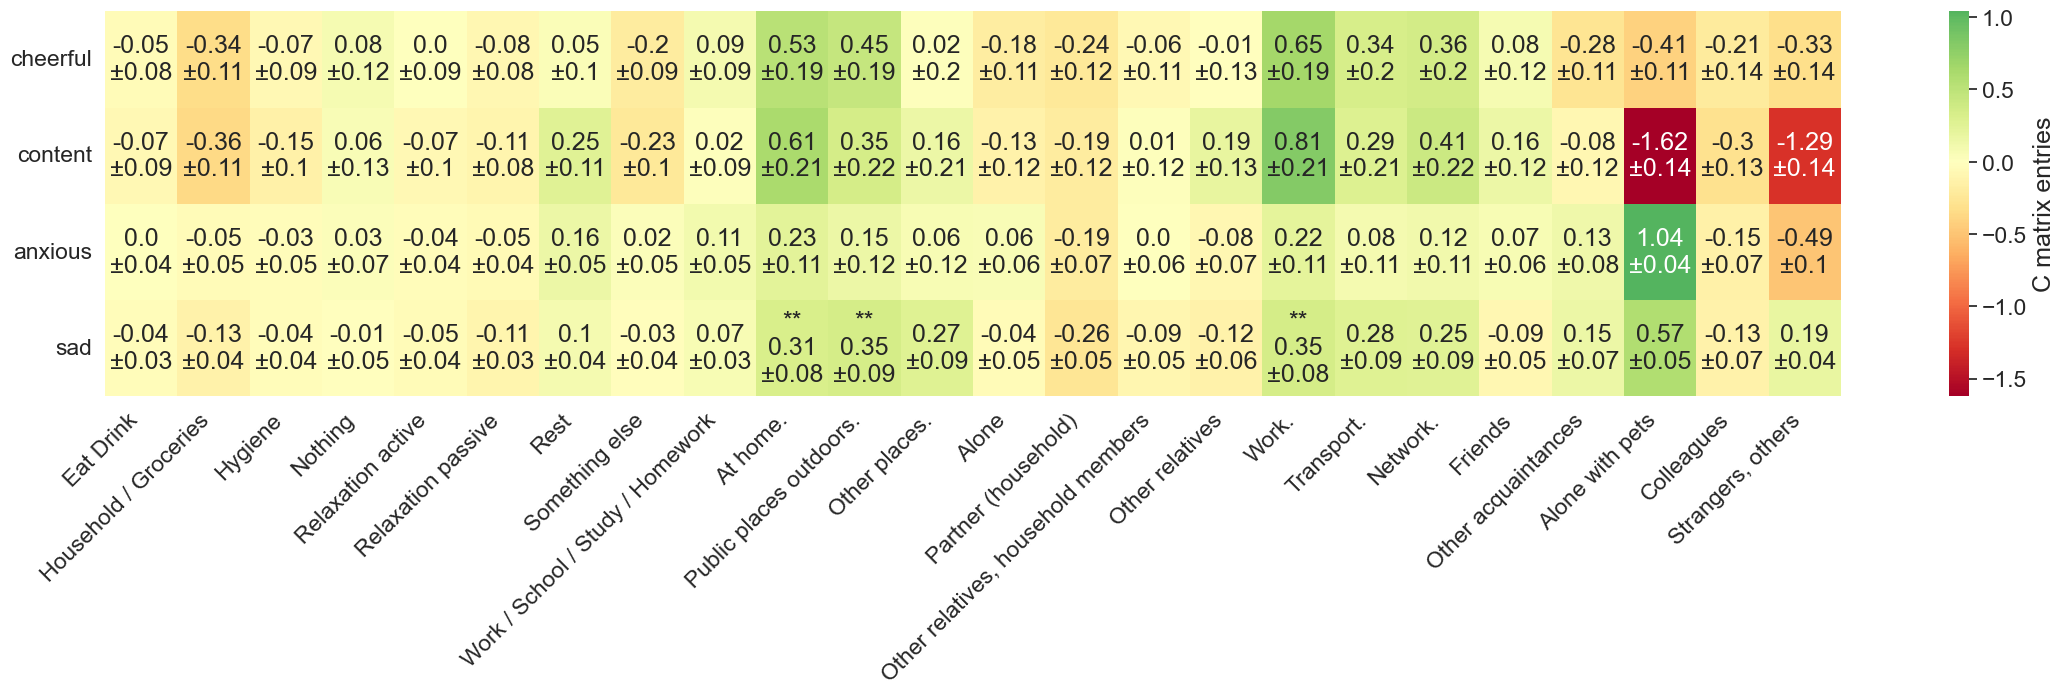

In [10]:
# Significant control matrix elements
m,n,foo = np.shape(dynamics['conmatrix'])
annotation = np.full([m,n], np.nan, dtype=object)
for i in range(m):
    for j in range(n):
        idx = ~np.isnan(dynamics['conmatrix'][i,j,:])
        t, p = scipy.stats.ttest_1samp(dynamics['conmatrix'][i,j,idx], 0)
        
        annotation[i,j] = str(np.round(np.nanmean(dynamics['conmatrix'][i,j,:]),2)) + '\n±'  + \
        str(np.round(np.nanstd(dynamics['conmatrix'][i,j,:])/np.sqrt(len(dynamics['conmatrix'][i,j,:])),2))
        if p < 0.05/(n*m):
            annotation[i,j] = '**\n' + annotation[i,j]
            print([mood_columns[i],input_columns[j],np.nanmean(dynamics['conmatrix'][i,j,idx]), t,p])
print('multiple comparison: ' + str(0.05/(n*m)))

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(28,5)) 
b=sns.heatmap(np.nanmean(dynamics['conmatrix'],axis=2), ax=ax, annot=annotation, fmt='', xticklabels=input_columns, \
            yticklabels=mood_columns, cmap='RdYlGn', center=0, cbar_kws={'label': 'C matrix entries'})
b.set_xticklabels(input_columns, rotation=45, ha='right')
plt.yticks(rotation=0);

In [11]:
# Relation between total absolute input strength on mood item and depression score
score ='dep1'
cc = np.nanmean(np.abs(dynamics['conmatrix']),axis=1)

df_depression_totalC = pd.DataFrame()
for i in range(len(mood_columns)):
    idx = ~np.isnan(df_depression[score]) & ~np.isnan(cc[i,:])
    [r,p] = scipy.stats.spearmanr(df_depression[score][idx],cc[i,idx])
    df_depression_totalC.loc[i, 'rspear'] = np.round(r,2)
    df_depression_totalC.loc[i, 'pvalue'] = p
df_depression_totalC = stats.replace_small_pvalues(df_depression_totalC)
df_depression_totalC.index = mood_columns
df_depression_totalC

,rspear,pvalue
cheerful,-0.09,0.074
content,-0.10,0.031
anxious,0.24,$<$0.001
sad,0.14,0.004


In [12]:
# Relation between control matrix elements and depression score
score ='dep1'
c = len(df_input.columns[2:])*4
cc = np.reshape(dynamics['conmatrix'], (c, Nsj))

df_depression_Citems = pd.DataFrame()
for i in range(c):
    idx = ~np.isnan(df_depression[score]) & ~np.isnan(cc[i,:])
    [r,p] = scipy.stats.spearmanr(df_depression[score][idx],cc[i,idx])
    df_depression_Citems.loc[i, 'rspear'] = np.round(r,2)
    df_depression_Citems.loc[i, 'pvalue'] = p
    df_depression_Citems.loc[i, 'N'] = sum(~np.isnan(cc[i,:]))
df_depression_Citems = stats.replace_small_pvalues(df_depression_Citems)
df_depression_Citems.index = C_labels
df_depression_Citems[df_depression_Citems['pvalue'] < 0.05]

,rspear,pvalue,N
cheerful - Other places.,0.14,0.047,212.0
anxious - Network.,0.11,0.044,313.0


In [13]:
# Relation between number of inputs and depression score
sum_inp = np.full((len(df_input.columns[2:]), Nsj), np.nan)
for i in range(Nsj):
    sum_inp[actual_inputs[:,i]==1,i] = np.sum(data[i]['inp'],axis=1)
    
score ='dep1'
df_depression_inputs = pd.DataFrame()
for i in range(len(input_columns)):
    X = sum_inp[i,:]
    idx = ~np.isnan(df_depression[score]) & ~np.isnan(X)
    [r,p] = scipy.stats.spearmanr(df_depression[score][idx],X[idx])
    df_depression_inputs.loc[i, 'rspear'] = np.round(r,2)
    df_depression_inputs.loc[i, 'pvalue'] = p
    df_depression_inputs.loc[i, 'var'] = np.round(np.nanvar(sum_inp[i,:]),2)
    df_depression_inputs.loc[i, 'N'] = sum(~np.isnan(sum_inp[i,:]))
df_depression_inputs = stats.replace_small_pvalues(df_depression_inputs)
df_depression_inputs.index = input_columns
df_depression_inputs

/Users/jolandamalamud/opt/miniconda3/envs/esmssm/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,rspear,pvalue,var,N
Eat Drink,-0.05,0.316,46.34,435.0
Household / Groceries,0.03,0.542,10.78,328.0
Hygiene,-0.07,0.202,5.91,346.0
Nothing,-0.03,0.483,91.62,438.0
Relaxation active,-0.00,0.932,29.40,416.0
Relaxation passive,0.02,0.638,76.78,434.0
Rest,0.03,0.505,52.16,425.0
Something else,0.00,0.976,48.70,422.0
Work / School / Study / Homework,0.01,0.808,86.89,400.0
At home.,0.01,0.883,102.85,437.0
